# Spray boundary detection for pMDI Spray Images

This program reads output of image preprocessing script and attempts to define the spray spatial and temporay boundary.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 04/02/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [1]:
import numpy as np
import h5py
from scipy import ndimage
from skimage import morphology,segmentation
import os, time
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
filename="/Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.h5"

In [4]:
# Open up file and leave it open for reading frames on the fly (save RAM).
H=h5py.File(filename,'r')
data=H['bkgnd_removed_images/Iproc']
mask=H['bkgnd_removed_images/nozzle_mask']
print(data.shape)

(5177, 920, 896)


## Test on sample frame
Improve and re-apply mask

In [5]:
# Take a frame where there is a lot of spray (time-minimum?)
frame=data[1100,...];

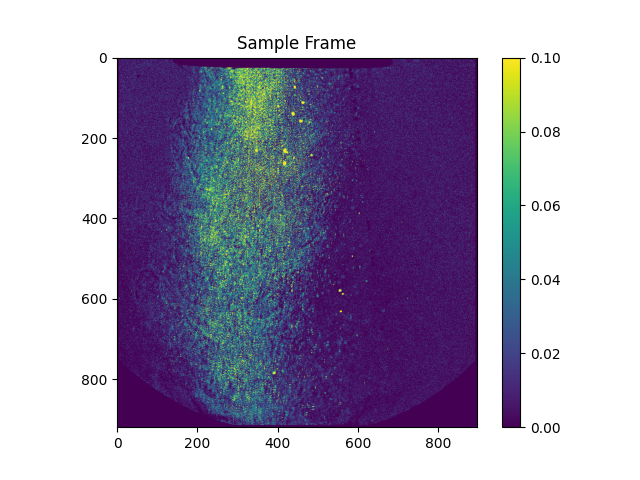

In [6]:
fig=plt.figure()
mask=H['bkgnd_removed_images/nozzle_mask']
mask=ndimage.binary_erosion(mask,iterations=5) # update mask
frame = frame*mask
p=plt.imshow(frame,vmin=0,vmax=0.1);
plt.colorbar(p);
plt.title("Sample Frame");

## Threshold-free segmentation of the spray

Requires that the segmented area be less than 50% (cumulative increasing intensity)

Background detection: removing labels up to 1/2277


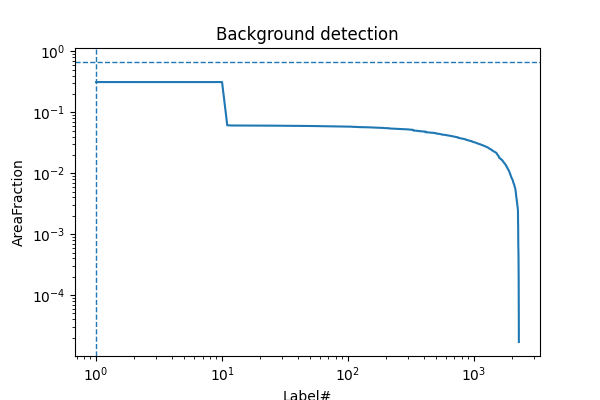

In [7]:
#Labels1 vy felz algo
labels1=segmentation.felzenszwalb(frame, scale=100, min_size=5, sigma=1.0).astype(np.uint16)
labels1=(labels1+1)*mask

#Labels2 is labels1 with background removed
areaFracMax=0.67
labels2=np.zeros_like(labels1)
nn=np.arange(1,np.nanmax(labels1)) # start at 1, 0 is mask.
nset=0
aa=[]
for n in nn:
    area=np.sum(labels1>n)/np.prod(frame.shape)
    if (area<areaFracMax)&(nset==0): # cut out background when cumulative area under some fraction
        nset=n
    aa.append(area)


print("Background detection: removing labels up to %i/%i" % (nset,labels1.max()))
labels2=(labels1>nset)

#Labels3 is Labels2 made contiguous.
labels3=morphology.remove_small_objects(labels2,min_size=128)
labels3=morphology.remove_small_holes(labels3,area_threshold=10)

plt.figure(figsize=(6,4))
plt.loglog(nn,aa);
plt.axhline(areaFracMax,ls='--',lw=1);
plt.axvline(nset,ls='--',lw=1);
plt.title("Background detection");
plt.xlabel("Label#"); plt.ylabel("AreaFraction");

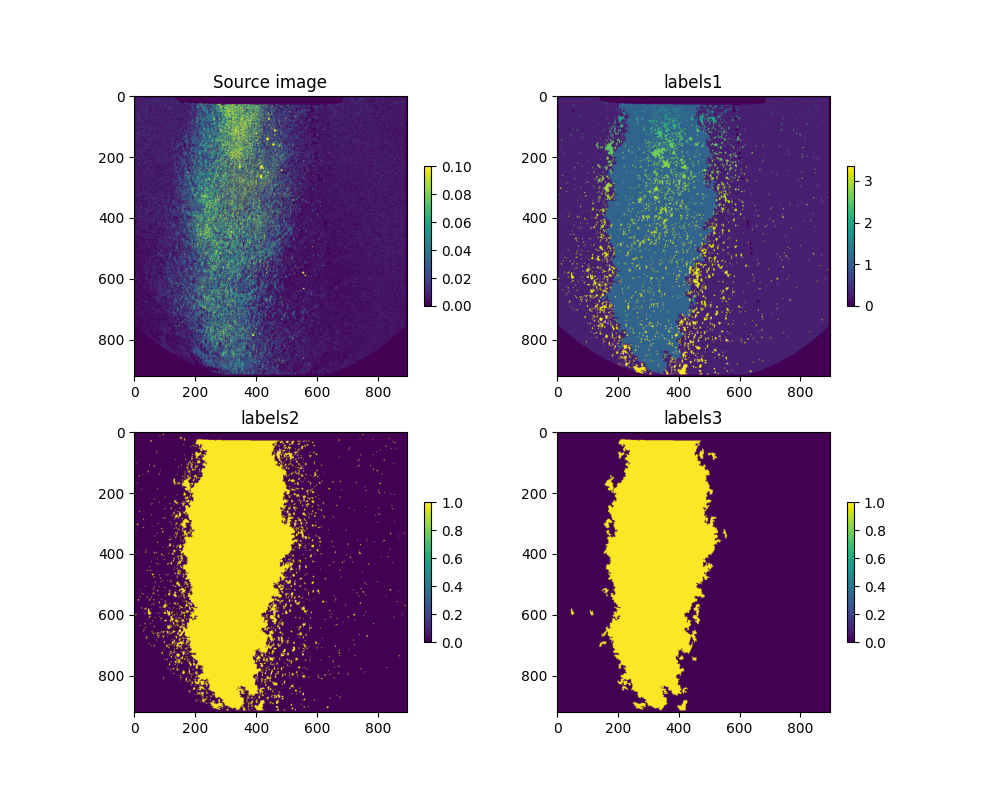

In [9]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(221)
p=plt.imshow(frame,vmin=0,vmax=0.1);
plt.colorbar(p,shrink=.5);
plt.title("Source image");

ax=fig.add_subplot(222)
p=plt.imshow(np.log10(labels1+1));
plt.colorbar(p,shrink=.5)
plt.title("labels1");

ax=fig.add_subplot(223)
p=plt.imshow(labels2);
plt.colorbar(p,shrink=.5);
plt.title("labels2");


ax=fig.add_subplot(224)
p=plt.imshow(labels3);
plt.colorbar(p,shrink=.5);
plt.title("labels3");

## Put the algorithm in a function and run it for all the frames.

In [10]:
def sprayBoundary(frame, mask, areaFracMax=0.67, scale=100, min_size=5, sigma=1.0):

    frameCopy = frame[...]*mask
    
    # Run felzenszwalb algorithm
    labels1=segmentation.felzenszwalb(frameCopy, scale=scale, min_size=min_size, sigma=sigma).astype(np.uint16)
    labels1=(labels1+1)*mask

    # Attempt to isolate background by label and area.
    labels2=np.zeros_like(labels1)
    nn=np.arange(1,np.nanmax(labels1))
    nset=0
    for n in nn:
        area=np.sum(labels1>n)/np.prod(frameCopy.shape)
        if (area<areaFracMax)&(nset==0): # cut out background when cumulative area under some fraction
            nset=n
            break
    
    #print("\tauto-threshold removing segments up to %i/%i" % (nset,labels1.max()))
    labels2=(labels1>nset)

    #Labels3 is Labels2 made contiguous.
    labels3=morphology.remove_small_objects(labels2,min_size=128)
    labels3=morphology.remove_small_holes(labels3,area_threshold=10)

    # Find edges of contiguous area
    edges=segmentation.find_boundaries(labels3,background=0)

    return labels1, labels2, labels3, nset, edges

In [11]:
settings={'areaFracMax':0.67, 'scale':100, 'min_size':5, 'sigma':1.0}

In [12]:
# Parallel
print("Processing %i images in parallel..." % data.shape[0])
results = Parallel(n_jobs=-1,verbose=10)(delayed(sprayBoundary)(data[i,...], mask, **settings) \
                                         for i in range(data.shape[0]))

Processing 5177 images in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  

## Save output to HDF5 File

In [ ]:
H.close() # close readonly

new_filename = os.path.splitext(filename)[0]+'_sprayBoundary.h5'
start_time = time.perf_counter()
chunks=(1,data.shape[1],data.shape[2])
with h5py.File(new_filename,'w') as H:
    G=H.create_group('spray_boundary_detection')
    
    d1=G.create_dataset('labels1_felzenszwalb',data.shape,chunks=chunks,dtype='uint16',compression='lzf')
    for var in settings.keys(): d1.attrs[var]=settings[var]

    d2=G.create_dataset('labels2_sprayBoundary',data.shape,chunks=chunks,dtype='bool',compression='lzf')
    d2.attrs['nset']=[np.array(results[j][3]) for j in range(len(results))]

    d3=G.create_dataset('labels3_sprayBoundaryContiguous',data.shape,chunks=chunks,dtype='bool',compression='lzf')

    d=G.create_dataset('mask',data=mask,dtype='bool')

    for j in tqdm(range(len(results))):
        d1[j,...]=results[j][0]
        d2[j,...]=results[j][1]
        d3[j,...]=results[j][2]
    
end_time = time.perf_counter()
print("Wrote %s [%.1f MB in %.1f s]" % (new_filename,os.path.getsize(new_filename)/1048576.,end_time-start_time))

## Plot Results

In [ ]:
area = np.array([ np.sum(results[i][2]) for i in range(len(results)) ])
peri = np.array([ np.sum(results[i][4]) for i in range(len(results)) ])

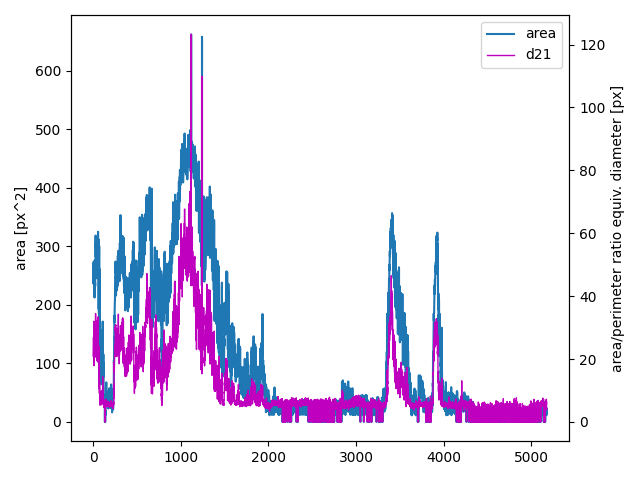

In [26]:

fig=plt.figure()
p1,=plt.plot(np.sqrt(area),label='area'); plt.ylabel('area [px^2]')
plt.twinx()
p2,=plt.plot(4*area/(peri+1e-6),label='d21',c='m',lw=1); plt.ylabel('area/perimeter ratio equiv. diameter [px]')
ll=(p1,p2)
plt.legend(ll,[l.get_label() for l in ll])
plt.tight_layout();
plt.show();